In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pickle
import pdb
import glob
import pandas as pd
import torch
from tqdm import tqdm

In [4]:
import sys
sys.path.append('/home/akumar/nse/neural_control')

In [25]:
from loaders import load_sabes, load_peanut

In [5]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from neurosim.models.ssr import StateSpaceRealization as SSR
from dca.cov_util import calc_cross_cov_mats_from_data, calc_pi_from_data
from dca_research.kca import calc_mmse_from_cross_cov_mats
from loaders import load_peanut
from utils import calc_loadings, apply_df_filters

### Peanut

In [140]:
with open('/home/akumar/nse/neural_control/data/peanut_dca_dimreduc.dat', 'rb') as f:
    dca_dimreduc_df = pickle.load(f)
# with open('../peanut_kca_dimreduc.dat', 'rb') as f:
#     kca_dimreduc_df = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/peanut_dca_decoding_df.dat', 'rb') as f:
    dca_decoding_df = pickle.load(f)
# with open('../')
# with open('../peanut_kca_decoding_df.dat', 'rb') as f:
#     kca_decoding_df = pickle.load(f)

In [141]:
fpath = '/mnt/Secondary/data/peanut/data_dict_peanut_day14.obj'

In [142]:
epochs = np.unique(dca_dimreduc_df['epoch'])

In [143]:
var_files = glob.glob('/mnt/Secondary/data/peanut_var2/peanut_var2_*.dat')
results_list = []
for var_file in var_files:
    result = {}
    with open(var_file, 'rb') as f:
        args = pickle.load(f)
        coefs = pickle.load(f)
        scores_and_supports = pickle.load(f)

    for key, value in args.items():
        if type(value) == dict:
            for key_, value_ in args[key].items():
                result[key_] = value_
        else:
            result[key] = value

    result['A'] = np.squeeze(coefs)
    results_list.append(result)
var_df = pd.DataFrame(results_list)

In [144]:
dca_r2_peanut = []
pca_r2_peanut = []

dim_vals = np.arange(1, 25)

for i, epoch in enumerate(epochs):
    
    ##### Decoding ######
    dca_df = apply_df_filters(dca_decoding_df, epoch=epoch, dr_method='DCA', ols_order=3, bin_width=25)
    fold_idxs = np.unique(dca_df['fold_idx'].values)
    dca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(dca_df, dim=dim_val, fold_idx=fold_idx)
            dca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    dca_r2_peanut.append(dca_r2_epoch)
    
    pca_df = apply_df_filters(dca_decoding_df, epoch=epoch, dr_method='PCA', ols_order=3, bin_width=25)
    pca_r2_epoch = np.zeros((dim_vals.size, fold_idxs.size))
    for j, dim_val in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(pca_df, dim=dim_val, fold_idx=fold_idx)
            pca_r2_epoch[j, k] = df_.iloc[0]['r2'][0]
    pca_r2_peanut.append(pca_r2_epoch)

In [145]:
peanut_dca_loadings_sorted = np.zeros((epochs.size, 25))
peanut_pca_loadings_sorted = np.zeros((epochs.size, 25))

peanut_dca_loadings = []
peanut_pca_loadings = []

peanut_subspaceangles = []

for i, epoch in enumerate(epochs):
    #### Loadings ######
    dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=3, 
                              fold_idx=1, dim=2, bin_width=25)
    pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=3, fold_idx=1,
                              bin_width=25)
    
    Vpca = pca_df.iloc[0]['coef'][:, 0:2]
    Vdca = dca_df.iloc[0]['coef']

    # peanut_dca_loadings_sorted[i, :] = np.sort(calc_loadings(dca_df.iloc[0]['coef']))[::-1][0:25]
    # peanut_pca_loadings_sorted[i, :] = np.sort(calc_loadings(pca_df.iloc[0]['coef'][:, 0:2]))[::-1][0:25]

    peanut_dca_loadings.extend(calc_loadings(dca_df.iloc[0]['coef']))
    peanut_pca_loadings.extend(calc_loadings(pca_df.iloc[0]['coef'][:, 0:2]))

    peanut_subspaceangles.append(np.mean(scipy.linalg.subspace_angles(Vpca, Vdca)))

peanut_subspaceangles = np.array(peanut_subspaceangles)


#### Single Unit Loading Calculations

In [54]:
# Calculate all folds
fold_idxs = [0, 1, 2, 3, 4]
pca_loadings = []
dca_loadings = []
su_var = []
su_pi = []
su_var_model = []
su_pi_model = []
su_Pmintrace = []
su_mmse = []

for ii, fold_idx in enumerate(fold_idxs):
    pca_loadings.append([])
    dca_loadings.append([])
    su_var.append([])
    su_pi.append([])
    su_var_model.append([])
    su_pi_model.append([])
    su_Pmintrace.append([])
    su_mmse.append([])    
    for i, epoch in tqdm(enumerate(epochs)):
        pca_loadings[ii].append([])
        dca_loadings[ii].append([])
        su_var[ii].append([])
        su_pi[ii].append([])
        su_var_model[ii].append([])
        su_pi_model[ii].append([])
        su_Pmintrace[ii].append([])
        su_mmse[ii].append([])    

        dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=3, fold_idx=fold_idx,
                                  dim=2, bin_width=25)
        pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=3, fold_idx=fold_idx,
                                  bin_width=25)
        var_df_ = apply_df_filters(var_df, epoch=epoch, bin_width=25)

        dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=dca_df.iloc[0]['bin_width'], 
                          filter_fn='none')

        cv = KFold(5, shuffle=False)
        train_idxs, test_idxs = next(cv.split(np.squeeze(dat['spike_rates'])))
        X = np.squeeze(dat['spike_rates'])[train_idxs, :]
        # X = StandardScaler().fit_transform(X)
        cross_cov_mats = calc_cross_cov_mats_from_data(X, T=6)
        ccmt = torch.tensor(cross_cov_mats)
        C1 = dca_df.iloc[0]['coef']
        C2 = pca_df.iloc[0]['coef'][:, 0:2]

        dca_loadings[ii][i].extend(calc_loadings(C1))
        pca_loadings[ii][i].extend(calc_loadings(C2))
        su_var[ii][i].extend(np.var(X, axis=0))
        for j in range(X.shape[1]):
            C = np.zeros((1, X.shape[1]))
            C[0, j] = 1
            ssr = SSR(A=var_df_.iloc[0]['A'], B = np.eye(var_df_.iloc[0]['A'].shape[0]), C=C)
            ssr.solve_min_phase()
            su_pi[ii][i].append(calc_pi_from_data(X, T=3, proj=C.T))
            su_pi_model[ii][i].append(ssr.pi(3))
            su_var_model[ii][i].append(ssr.cov[0][0])
            su_Pmintrace[ii][i].append(np.trace(ssr.Pmin)) 
            Ct = torch.tensor(C.T)
            su_mmse[ii][i].append(calc_mmse_from_cross_cov_mats(ccmt, Ct).numpy())

# Save these away for plotting below
pca_su_var_r2 = np.array([[scipy.stats.spearmanr(pca_loadings[ii][i], su_var[ii][i])[0]
                 for i in range(len(epochs))] for ii in range(len(fold_idxs))])
dca_su_var_r2 = np.array([[scipy.stats.spearmanr(dca_loadings[ii][i], su_var[ii][i])[0]
                for i in range(len(epochs))] for ii in range(len(fold_idxs))])
pca_su_pi_r2  = np.array([[scipy.stats.spearmanr(pca_loadings[ii][i], su_pi[ii][i])[0]
                 for i in range(len(epochs))] for ii in range(len(fold_idxs))])
dca_su_pi_r2 = np.array([[scipy.stats.spearmanr(dca_loadings[ii][i], su_pi[ii][i])[0]
                 for i in range(len(epochs))] for ii in range(len(fold_idxs))])
pca_su_mmse_r2 = np.array([[scipy.stats.spearmanr(pca_loadings[ii][i], su_Pmintrace[ii][i])[0]
                   for i in range(len(epochs))] for ii in range(len(fold_idxs))])
dca_su_mmse_r2 = np.array([[scipy.stats.spearmanr(dca_loadings[ii][i], su_Pmintrace[ii][i])[0]
                   for i in range(len(epochs))] for ii in range(len(fold_idxs))])
pca_su_var_r2.shape

8it [00:34,  4.33s/it]
8it [00:34,  4.28s/it]
8it [00:35,  4.38s/it]
8it [00:34,  4.37s/it]
8it [00:34,  4.29s/it]


(5, 8)

In [101]:
from decoders import lr_decoder, lr_encoder

In [102]:
decoder_params = {'trainlag': 0, 'testlag': 0, 'decoding_window': 6}

result_list = []
for i, epoch in tqdm(enumerate(epochs)):
    for ii, fold_idx in enumerate(fold_idxs):
        result = {}
        result['epoch'] = epoch
        result['fold_idx'] = fold_idx
        dca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='DCA', ols_order=3, fold_idx=fold_idx,
                                  bin_width=25)
        pca_df = apply_df_filters(dca_dimreduc_df, epoch=epoch, dimreduc='PCA', ols_order=3, fold_idx=fold_idx,
                                  bin_width=25)

        dat = load_peanut(fpath, epoch, spike_threshold=200, bin_width=dca_df.iloc[0]['bin_width'], 
                          filter_fn='none')

        X = np.squeeze(dat['spike_rates'])
        Z = dat['behavior']
df_ = apply_df_filters(dimreduc_df, dimreduc='PCA', fold_idx=0, dim=2)
V = df_.iloc[0]['coef']
CV_loadingsPCA = calc_loadings(V, 1)


# DCA
df_ = apply_df_filters(dimreduc_df, dimreduc='DCA', fold_idx=0, dim=2)

        kfold = KFold(n_splits=5, shuffle=False)
        train_idxs, test_idxs = list(kfold.split(X))[fold_idx]
        ztrain = Z[train_idxs, :]
        ztest = Z[test_idxs, :]

        # Population level decoding/encoding - use the coefficient in the linear fit
        # Record both the weights in the coefficient but also the loadings onto the SVD

        xtrain = X[train_idxs, :]
        xtest = X[test_idxs, :]

        _, _, _, decodingregressor = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
        _, encodingregressor = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)

        result['decoding_weights'] = decodingregressor.coef_
        result['encoding_weights'] = encodingregressor.coef_

        u1, s1, vh1 = np.linalg.svd(decodingregressor.coef_[0:2, :], full_matrices=False)
        u4, s4, vh4 = np.linalg.svd(encodingregressor.coef_, full_matrices=False)

        result['decoding_pos_svd'] = vh1
        result['encoding_svd'] = u4

        r2_pos_decoding = []
        r2_encoding = []

        decoding_weights = []
        encoding_weights = []

        decoding_weights_svd = []
        encoding_weights_svd = []


        for neu_idx in range(X.shape[1]):           #Fit all neurons one by one

            xtrain = X[train_idxs, neu_idx][:, np.newaxis]
            xtest = X[test_idxs, neu_idx][:, np.newaxis]
            # Decoding
            r2_pos, _, _, dr = lr_decoder(xtest, xtrain, ztest, ztrain, **decoder_params)
            r2_pos_decoding.append(r2_pos)        
            decoding_weights.append(dr.coef_)

            # Encoding
            r2_encoding_, er = lr_encoder(xtest, xtrain, ztest, ztrain, **decoder_params)
            r2_encoding.append(r2_encoding_)
            encoding_weights.append(er.coef_)        

        result['su_r2_pos_decoding'] = r2_pos_decoding
        result['su_r2_encoding'] = r2_encoding
        result['su_decoding_weight'] = decoding_weights
        result['su_encoding_weight'] = encoding_weights        

        dim_vals = np.arange(2, 25)
        dca_loadings = np.zeros((dim_vals.size, X.shape[1]))
        pca_loadings = np.zeros((dim_vals.size, X.shape[1]))

        for i, dim_ in enumerate(dim_vals):
            dca_df_ = dca_df.loc[dca_df['dim'] == dim_]
            dca_loadings[i, :] = calc_loadings(dca_df_.iloc[0]['coef'])
            pca_loadings[i, :] = calc_loadings(pca_df.iloc[0]['coef'][:, 0:dim_])

        result['dca_loadings'] = dca_loadings
        result['pca_loadings'] = pca_loadings
    
        result_list.append(result)

result_list = pd.DataFrame(result_list)

8it [02:52, 21.58s/it]


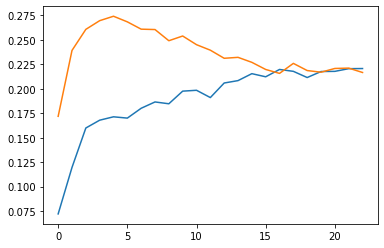

In [107]:
# For each quantity, calculate the spearman r2 
dca_decoding_weightsr2 = np.zeros((len(fold_idxs), len(epochs), dim_vals.size))
dca_decoding_svdr2 = np.zeros((len(fold_idxs), len(epochs), dim_vals.size))
pca_decoding_weightsr2 = np.zeros((len(fold_idxs), len(epochs), dim_vals.size))
pca_decoding_svdr2 = np.zeros((len(fold_idxs), len(epochs), dim_vals.size))

for j, epoch in enumerate(epochs):
    for k, fold_idx in enumerate(fold_idxs):
        for i, dim in enumerate(dim_vals):

            y_dca = []
            y_pca = []

            # Decoding weights
            x1 = [] 
            # Decoding SVD weights
            x2 = []

            df_ = apply_df_filters(result_list, fold_idx=fold_idx, epoch=epoch)
            y_dca.extend(df_.iloc[0]['dca_loadings'][i, :])
            y_pca.extend(df_.iloc[0]['pca_loadings'][i, :])

            x1.extend(calc_loadings(df_.iloc[0]['decoding_weights'][0:2, :].T, 6))
            x2.extend(calc_loadings(df_.iloc[0]['decoding_pos_svd'].T, 6))

            dca_decoding_weightsr2[k, j, i] = scipy.stats.spearmanr(x1, y_dca)[0]
            dca_decoding_svdr2[k, j, i] = scipy.stats.spearmanr(x2, y_dca)[0]

            pca_decoding_weightsr2[k, j, i] = scipy.stats.spearmanr(x1, y_pca)[0]
            pca_decoding_svdr2[k, j, i] = scipy.stats.spearmanr(x2, y_pca)[0]

peanut_dca_decoding_weightsr = np.mean(np.mean(dca_decoding_weightsr2, axis=1), axis=0)
peanut_pca_decoding_weightsr = np.mean(np.mean(pca_decoding_weightsr2, axis=1), axis=0)


plt.plot(peanut_dca_decoding_weightsr)
plt.plot(peanut_pca_decoding_weightsr)

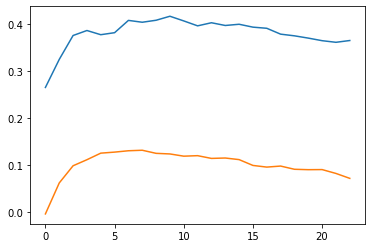

In [111]:
# For each quantity, calculate the spearman r2 
dca_suencoding_r = np.zeros((len(fold_idxs), len(epochs), dim_vals.size))
pca_suencoding_r = np.zeros((len(fold_idxs), len(epochs), dim_vals.size))

for j, epoch in enumerate(epochs):
    for k, fold_idx in enumerate(fold_idxs):
        for i, dim in enumerate(dim_vals):

            y_dca = []
            y_pca = []

            # Encoding r2
            x1 = [] 

            df_ = apply_df_filters(result_list, fold_idx=fold_idx, epoch=epoch)
            y_dca.extend(df_.iloc[0]['dca_loadings'][i, :])
            y_pca.extend(df_.iloc[0]['pca_loadings'][i, :])
            x1.extend(df_.iloc[0]['su_r2_encoding'])

            dca_suencoding_r[k, j, i] = scipy.stats.spearmanr(x1, y_dca)[0]
            pca_suencoding_r[k, j, i] = scipy.stats.spearmanr(x1, y_pca)[0]


peanut_dca_suencoding_r = np.mean(np.mean(dca_suencoding_r,axis=1), axis=0)
peanut_pca_suencoding_r = np.mean(np.mean(pca_suencoding_r,axis=1), axis=0)

# peanut_dca_decoding_weightsr = np.mean(np.mean(dca_decoding_weightsr2, axis=1), axis=0)
# peanut_pca_decoding_weightsr = np.mean(np.mean(pca_decoding_weightsr2, axis=1), axis=0)


plt.plot(peanut_dca_suencoding_r)
plt.plot(peanut_pca_suencoding_r)

### Sabes

In [146]:
with open('/home/akumar/nse/neural_control/data/sabes_decoding_df.dat', 'rb') as f:
    decoding_df = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/sabes_dimreduc_df.dat', 'rb') as f:
    dimreduc_df = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/sabes_var_df.dat', 'rb') as f:
    var_df = pickle.load(f)

In [147]:
data_files = np.unique(var_df['data_file'].values)

In [148]:
dim_vals = np.arange(1, 50)
fold_idxs = np.unique(decoding_df['fold_idx'].values)
dca_r2_sabes = np.zeros((len(data_files), dim_vals.size, fold_idxs.size, 3))
pca_r2_sabes = np.zeros((len(data_files), dim_vals.size, fold_idxs.size, 3))
for i, data_file in enumerate(data_files):
    for j, dim in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):
            df_ = apply_df_filters(decoding_df, data_file=data_file, dim=dim, fold_idx=fold_idx)
                
            dca_r2_sabes[i, j, k, :] = apply_df_filters(df_, dimreduc='DCA').iloc[0]['r2'][:]
            pca_r2_sabes[i, j, k, :] = apply_df_filters(df_, dimreduc='PCA').iloc[0]['r2'][:]
                

In [149]:
# Consult loadingsVSRsquared notebook
with open('/home/akumar/nse/neural_control/data/sabes_loadings_v_r2.dat', 'rb') as f:
    #_ = pickle.load(f)
    result = pickle.load(f)

In [150]:
# Decoding weight
sabes_dca_decoding_weightsr2 = np.zeros(dim_vals.size)
sabes_dca_decoding_svdr2 = np.zeros(dim_vals.size)
sabes_pca_decoding_weightsr2 = np.zeros(dim_vals.size)
sabes_pca_decoding_svdr2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        
        x1.extend(calc_loadings(result[data_file]['decoding_weights'][2:4, :].T, 3))
        x2.extend(calc_loadings(result[data_file]['decoding_vel_svd'].T, 3))

    sabes_dca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    sabes_dca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_dca)[0]
    
    sabes_pca_decoding_weightsr2[i] = scipy.stats.spearmanr(x1, y_pca)[0]
    sabes_pca_decoding_svdr2[i] = scipy.stats.spearmanr(x2, y_pca)[0]

In [117]:
# Encoding r2
sabes_dca_suencoding_r2 = np.zeros(dim_vals.size)
sabes_pca_suencoding_r2 = np.zeros(dim_vals.size)

for i, dim in enumerate(dim_vals):
    y_dca = []
    y_pca = []
    
    # Decoding weights
    x1 = [] 
    # Decoding SVD weights
    x2 = []
    
    for data_file in data_files:
        y_dca.extend(result[data_file]['dca_loadings'][i, :])
        y_pca.extend(result[data_file]['pca_loadings'][i, :])
        x1.extend(result[data_file]['su_r2_encoding'])

    sabes_dca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_dca)[0]
    sabes_pca_suencoding_r2[i] = scipy.stats.spearmanr(x1, y_pca)[0]

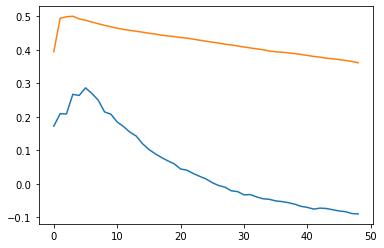

In [119]:
plt.plot(sabes_dca_suencoding_r2)
plt.plot(sabes_pca_suencoding_r2)

In [28]:
with open('/home/akumar/nse/neural_control/data/hwni_preprocessed.dat', 'rb') as f:
    variance = pickle.load(f)
    pi = pickle.load(f)

In [30]:
xx = []
yy = []

ww = []
zz = []

for i, data_file in enumerate(data_files):
    df = apply_df_filters(var_df, data_file=data_file, fold_idx=0)
    pca_df = apply_df_filters(dimreduc_df, data_file=data_file, fold_idx=0, dimreduc='PCA')
    dca_df = apply_df_filters(dimreduc_df, data_file=data_file, fold_idx=0, dimreduc='DCA', dim=2)
    
    xx.extend(np.diag(df.iloc[0]['W'])/np.max(np.diag(df.iloc[0]['W'])))
    yy.extend(calc_loadings(pca_df.iloc[0]['coef'][:, 0:2], 1))
    
    ww.extend(pi[data_file]['modelT5'])
    zz.extend(calc_loadings(dca_df.iloc[0]['coef'], 1))

xx = np.array(xx)
yy = np.array(yy)
ww = np.array(ww)
zz = np.array(zz)

sabes_r2_supca_pca = scipy.stats.spearmanr(yy, xx)[0]
sabes_r2_sudca_dca = scipy.stats.spearmanr(zz, ww)[0]
sabes_r2_sudca_pca = scipy.stats.spearmanr(yy, ww)[0]
sabes_r2_supca_dca = scipy.stats.spearmanr(zz, xx)[0]

In [151]:
loadingsPCA = []
loadingsW = []
loadingsDCA = []

subspace_angles = []

for i, data_file in enumerate(data_files):
    
    # SCAD
    df_ = apply_df_filters(var_df, fold_idx=0, data_file=data_file)
    
    W = df_.iloc[0]['W']
    eig, U = np.linalg.eig(W)
    eigorder = np.argsort(np.abs(eig))[::-1]
    U = U[:, eigorder]
    loadingsW.extend(calc_loadings(U[:, 0:2], 1))

    # PCA
    df_ = apply_df_filters(dimreduc_df, dimreduc='PCA', data_file=data_file, fold_idx=0)
    Vpca = df_.iloc[0]['coef'][:, 0:2]
    loadingsPCA.extend(calc_loadings(Vpca, 1))

    # DCA
    df_ = apply_df_filters(dimreduc_df, dimreduc='DCA', data_file=data_file, fold_idx=0, dim=2)
    Vdca = df_.iloc[0]['coef']
    loadingsDCA.extend(calc_loadings(Vdca, 1))

    subspace_angles.append(np.mean(scipy.linalg.subspace_angles(Vpca, Vdca)))

sabes_loadingsW = np.array(loadingsW)
sabes_loadingsPCA = np.array(loadingsPCA)
sabes_loadingsDCA = np.array(loadingsDCA)
sabes_subspaceangles = np.array(subspace_angles)

Text(0, 0.5, 'Linear Correlation')

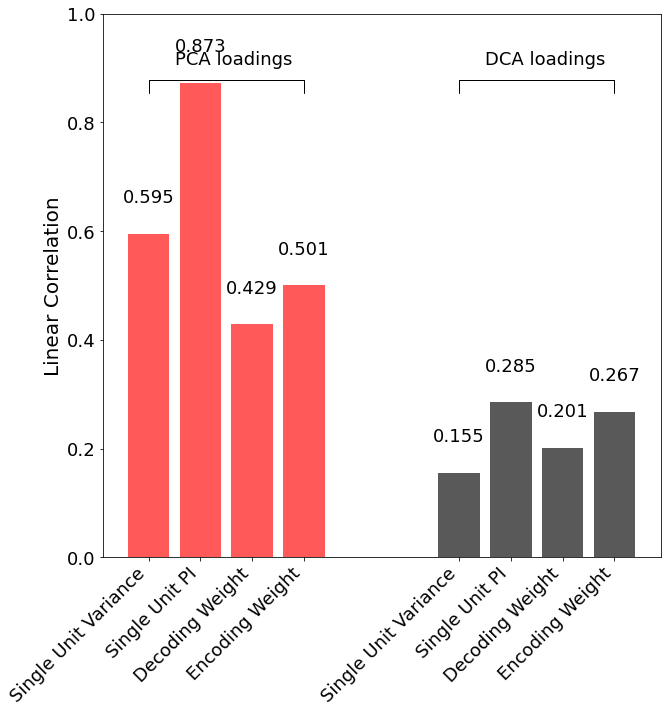

In [132]:
fig, ax = plt.subplots(figsize=(10, 10), )

bars = ax.bar([0, 1, 2, 3, 6, 7, 8, 9], [sabes_r2_supca_pca, sabes_r2_sudca_pca,  sabes_pca_decoding_weightsr2[1], sabes_pca_suencoding_r2[3],
                                         max(0, sabes_r2_supca_dca), sabes_r2_sudca_dca, sabes_dca_decoding_weightsr2[1], sabes_dca_suencoding_r2[3]],
              color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65)

# Place numerical values above the bars
for rect in bars: 
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, '%.3f' % rect.get_height(),
            ha='center', va='bottom', fontsize=18)
    
ax.set_ylim([0, 1])
ax.set_xticks([0, 1, 2, 3, 6, 7, 8, 9])
ax.set_xticklabels(['Single Unit Variance', 'Single Unit PI', 'Decoding Weight', 'Encoding Weight',
                    'Single Unit Variance', 'Single Unit PI', 'Decoding Weight', 'Encoding Weight'],
                   rotation=45, fontsize=18, ha='right')
ax.tick_params(axis='y', labelsize=18)
ax.text(0.5, 0.9, 'PCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(0, 0.85), xytext=(3, 0.85), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))


ax.text(6.5, 0.9, 'DCA loadings', fontsize=18, ha='left', va='bottom')
ax.annotate("", xy=(6, 0.85), xytext=(9, 0.85), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax.set_ylabel('Linear Correlation', fontsize=20)
#fig.savefig('hwni/loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)

### CV

In [126]:
with open('/home/akumar/nse/neural_control/data/cv_decoding_results.dat', 'rb') as f:
    cv_decoding_df = pickle.load(f)
with open('/home/akumar/nse/neural_control/data/cv_dimreduc_results.dat', 'rb') as f:
    cv_dimreduc_df = pickle.load(f)

In [58]:
T = np.unique(cv_decoding_df['T'].values)

In [81]:
dim_vals = np.arange(2, 24)
fold_idxs = np.unique(decoding_df['fold_idx'].values)
dca_r2_cv = np.zeros((T.size, dim_vals.size, fold_idxs.size))
pca_r2_cv = np.zeros((T.size, dim_vals.size, fold_idxs.size))
kca_r2_cv = np.zeros((T.size, dim_vals.size, fold_idxs.size))

for i, T_ in enumerate(T):
    for j, dim in enumerate(dim_vals):
        for k, fold_idx in enumerate(fold_idxs):

            df_ = apply_df_filters(cv_decoding_df, T=T_, dim=dim, fold_idx=fold_idx)                
            dca_r2_cv[i, j, k] = apply_df_filters(df_, dimreduc_method='DCA').iloc[0]['score']
            pca_r2_cv[i, j, k] = apply_df_filters(df_, dimreduc_method='PCA').iloc[0]['score']
            kca_r2_cv[i, j, k] = apply_df_filters(df_, dimreduc_method='KCA').iloc[0]['score']

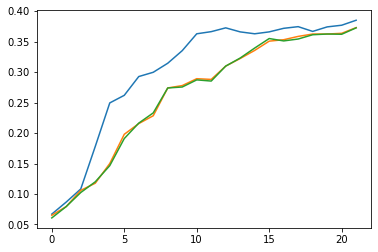

In [82]:
plt.plot(np.mean(dca_r2_cv[0, :], axis=-1))
# plt.plot(np.mean(dca_r2_cv[1, :], axis=-1))
# plt.plot(np.mean(dca_r2_cv[2, :], axis=-1))
plt.plot(np.mean(pca_r2_cv[0, :], axis=-1))
plt.plot(np.mean(kca_r2_cv[2, :], axis=-1))


In [152]:
df_ = apply_df_filters(var_df, fold_idx=0, data_file=data_file)

# PCA
df_ = apply_df_filters(cv_dimreduc_df, fold_idx=0, dim=2, T=1)
Vpca = df_.iloc[0]['PCA']['coef']
CV_loadingsPCA = calc_loadings(Vpca, 1)


# DCA
df_ = apply_df_filters(cv_dimreduc_df, fold_idx=0, dim=2, T=1)
Vdca = df_.iloc[0]['DCA']['coef']
CV_loadingsDCA = calc_loadings(Vdca, 1)

CV_subspace_angles = [np.mean(scipy.linalg.subspace_angles(Vdca, Vpca))]

### Plots

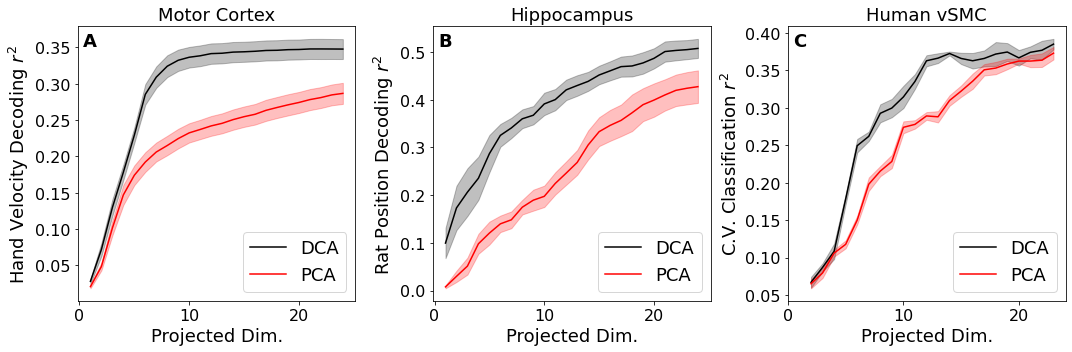

In [196]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

labels = ['DCA', 'PCA']
colors = ['black', 'red']
ndims = 24
dim_vals = np.arange(ndims) + 1

for i, r2_ in enumerate([dca_r2_sabes, pca_r2_sabes]):
    r2_ = np.nanmean(r2_, axis=2)
    r2_mean = np.nanmean(r2_, axis=0)
    r2_std = np.std(r2_, axis=0)/np.sqrt(r2_.shape[0])
    
    ax[0].plot(dim_vals, r2_mean[np.arange(ndims), 0], label=labels[i], color=colors[i])
    ax[0].fill_between(dim_vals, r2_mean[np.arange(ndims), 0] - r2_std[np.arange(ndims), 0], r2_mean[np.arange(ndims), 0] + r2_std[np.arange(ndims), 0], alpha=0.25, 
                        color=colors[i])


for i, r2_ in enumerate([dca_r2_peanut, pca_r2_peanut]):
    r2_ = np.array([np.mean(r2_[i], axis=1) for i in [0, 1, 3, 4, 5, 6, 7]])
    r2_mean = np.nanmean(r2_, axis=0)
    r2_std = np.std(r2_, axis=0)/np.sqrt(r2_.shape[0])

    ax[1].plot(dim_vals, r2_mean[np.arange(ndims)], label=labels[i], color=colors[i])
    ax[1].fill_between(dim_vals, r2_mean[np.arange(ndims)] - r2_std[np.arange(ndims)], r2_mean[np.arange(ndims)] + r2_std[np.arange(ndims)], alpha=0.25, 
                        color=colors[i])


for i, r2_ in enumerate([dca_r2_cv, pca_r2_cv]):
    #r2_ = np.array([np.mean(r2_, axis=-1) for i in [0, 1, 3, 4, 5, 6, 7]])
    r2_mean = np.nanmean(r2_[0, ...], axis=-1)
    r2_std = np.std(r2_[0, ...], axis=-1)/np.sqrt(r2_.shape[-1])

    ax[2].plot(np.arange(2, 24), r2_mean, label=labels[i], color=colors[i])
    ax[2].fill_between(np.arange(2, 24), r2_mean - r2_std, r2_mean + r2_std, alpha=0.25, 
                        color=colors[i])


ax[0].legend(['DCA', 'PCA'], fontsize=18, loc='lower right')
ax[0].set_xlabel('Projected Dim.', fontsize=18)
ax[0].set_ylabel('Hand Velocity Decoding ' + r'$r^2$', fontsize=18)
ax[0].tick_params(axis='both', labelsize=16)

ax[1].legend(['DCA', 'PCA'], fontsize=18, loc='lower right')
ax[1].set_xlabel('Projected Dim.', fontsize=18)
ax[1].set_ylabel('Rat Position Decoding ' + r'$r^2$', fontsize=18)
ax[1].tick_params(axis='both', labelsize=16)

ax[2].legend(['DCA', 'PCA'], fontsize=18, loc='lower right')
ax[2].set_xlabel('Projected Dim.', fontsize=18)
ax[2].set_ylabel('C.V. Classification ' + r'$r^2$', fontsize=18)
ax[2].set_xticks([0, 10, 20])
ax[2].tick_params(axis='both', labelsize=16)

ax[0].set_title('Motor Cortex', fontsize=18)
ax[1].set_title('Hippocampus', fontsize=18)
ax[2].set_title('Human vSMC', fontsize=18)


ax[0].text(0.02, 0.98, 'A', transform=ax[0].transAxes,
          fontsize=18, fontweight='bold', va='top')    
ax[1].text(0.02, 0.98, 'B', transform=ax[1].transAxes,
          fontsize=18, fontweight='bold', va='top')    
ax[2].text(0.02, 0.98, 'C', transform=ax[2].transAxes, fontsize=18, 
         fontweight='bold', va='top')

fig.tight_layout()

#fig.subplots_adjust(wspace=0.45, hspace=0.325)
fig.savefig('decoding.pdf', bbox_inches='tight', pad_inches=0)


In [120]:
pca_su_var_r2

array([[0.88381933, 0.94097497, 0.93403316, 0.94396065, 0.94299307,
        0.87155298, 0.91435407, 0.91909796],
       [0.8987612 , 0.88234519, 0.94819515, 0.93984841, 0.94065473,
        0.87219803, 0.91551606, 0.90218464],
       [0.8989899 , 0.85494071, 0.95468963, 0.94936301, 0.93759071,
        0.84687954, 0.89794942, 0.87878788],
       [0.89243377, 0.88194993, 0.95755929, 0.9405741 , 0.93049508,
        0.85615223, 0.91120984, 0.88231149],
       [0.88519154, 0.86890646, 0.95861653, 0.93896146, 0.93484922,
        0.85937752, 0.89685578, 0.88794926]])

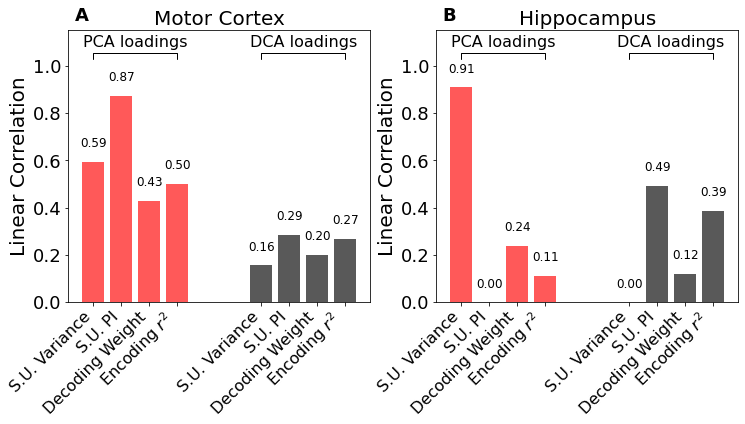

In [195]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

bars = ax[0].bar([0, 1, 2, 3, 6, 7, 8, 9], [sabes_r2_supca_pca, sabes_r2_sudca_pca,  sabes_pca_decoding_weightsr2[1], sabes_pca_suencoding_r2[3],
                                         max(0, sabes_r2_supca_dca), sabes_r2_sudca_dca, sabes_dca_decoding_weightsr2[1], sabes_dca_suencoding_r2[3]],
              color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65)

# Place numerical values above the bars
for rect in bars: 
    ax[0].text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, '%.2f' % rect.get_height(),
            ha='center', va='bottom', fontsize=12)
    
ax[0].set_ylim([0, 1.15])
ax[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].set_xticks([0, 1, 2, 3, 6, 7, 8, 9])
ax[0].set_xticklabels(['S.U. Variance', 'S.U. PI', 'Decoding Weight', 'Encoding ' + r'$r^2$',
                       'S.U. Variance', 'S.U. PI', 'Decoding Weight', 'Encoding ' + r'$r^2$'],
                   rotation=45, fontsize=16, ha='right')
ax[0].tick_params(axis='y', labelsize=18)
ax[0].text(1.5, 1.07, 'PCA loadings', fontsize=16, ha='center', va='bottom')
ax[0].annotate("", xy=(0, 1.02), xytext=(3, 1.02), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))


ax[0].text(7.5, 1.07, 'DCA loadings', fontsize=16, ha='center', va='bottom')
ax[0].annotate("", xy=(6, 1.02), xytext=(9, 1.02), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax[0].set_ylabel('Linear Correlation', fontsize=20)


bars = ax[1].bar([0, 1, 2, 3, 6, 7, 8, 9], [np.mean(pca_su_var_r2), max(0, np.mean(pca_su_pi_r2)),  peanut_pca_decoding_weightsr[1], peanut_pca_suencoding_r[3],
                                            max(0, np.mean(dca_su_var_r2)), max(0, np.mean(dca_su_pi_r2)), peanut_dca_decoding_weightsr[1], peanut_dca_suencoding_r[3]],
              color=['r', 'r', 'r', 'r', 'k', 'k', 'k', 'k'], alpha=0.65)

# Place numerical values above the bars
for rect in bars: 
    ax[1].text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.05, '%.2f' % rect.get_height(),
            ha='center', va='bottom', fontsize=12)
    
ax[1].set_ylim([0, 1.15])
ax[1].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[1].set_xticks([0, 1, 2, 3, 6, 7, 8, 9])
ax[1].set_xticklabels(['S.U. Variance', 'S.U. PI', 'Decoding Weight', 'Encoding ' + r'$r^2$',
                       'S.U. Variance', 'S.U. PI', 'Decoding Weight', 'Encoding ' + r'$r^2$'],
                   rotation=45, fontsize=16, ha='right')
ax[1].tick_params(axis='y', labelsize=18)
ax[1].text(1.5, 1.07, 'PCA loadings', fontsize=16, ha='center', va='bottom')
ax[1].annotate("", xy=(0, 1.02), xytext=(3, 1.02), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))


ax[1].text(7.5, 1.07, 'DCA loadings', fontsize=16, ha='center', va='bottom')
ax[1].annotate("", xy=(6, 1.02), xytext=(9, 1.02), 
            xycoords='data', textcoords='data',
            arrowprops=dict(arrowstyle='-', connectionstyle='bar,fraction=0.1'))

ax[1].set_ylabel('Linear Correlation', fontsize=20)
fig.subplots_adjust(wspace=0.22)

ax[0].set_title('Motor Cortex', fontsize=20)
ax[1].set_title('Hippocampus', fontsize=20)

ax[0].text(0.02, 1.02, 'A', transform=ax[0].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    
ax[1].text(0.02, 1.02, 'B', transform=ax[1].transAxes,
          fontsize=18, fontweight='bold', va='bottom')    

fig.savefig('loadings_correlation.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
# Lack of correlation between loadings - put all 3 datasets in a single plot
ssr = SSR(A=A)